In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [4]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [6]:
discipline = "Mathematics"

In [7]:
foo = data_grouped_by_year_label[["Label"]].groupby(data_grouped_by_year_label.Label).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
foo.head(30)


,Label,counts
248,Zoology,117
87,Evolutionary Biology,117
33,"Chemistry, Inorganic & Nuclear",117
85,Ethics,117
35,"Chemistry, Multidisciplinary",117
139,"Materials Science, Multidisciplinary",117
201,Psychology,117
39,Clinical Neurology,117
200,Psychiatry,117
197,Political Science,117


In [8]:
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [9]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words
11092,11092,Mathematics,1900,[theory infinite integrable total differential...,"[note geometrical treatment conics , simple pr...",note geometrical treatment conics simple proo...,note geometrical treatment conics simple proof...
11093,11093,Mathematics,1901,[registraton laws colonies massachusetts plymo...,[representation linear groups transitive subst...,representation linear groups transitive substi...,representation linear groups transitive substi...
11094,11094,Mathematics,1902,"[research elliptical functions , research elli...","[what center area center population , number ...",what center area center population number ar...,what center area center population number arra...
11095,11095,Mathematics,1903,"[mortality investigation, note statistics pros...","[problem inversion resolved abel, jews prussia...",problem inversion resolved abel jews prussia g...,problem inversion resolved abel jews prussia g...
11096,11096,Mathematics,1904,"[dirichlet s principle , dirichlet s principle...",[group theory applications theory linear homog...,group theory applications theory linear homoge...,group theory applications theory linear homoge...


In [10]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

In [11]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

In [12]:
vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [13]:
vectorized_wordarray.shape

(117, 102930)

In [14]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:00<00:00, 136.13it/s]


In [15]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

__Frequency Variations:__ Words which have a frequency of 20 in year Y<sub>t</sub>. How much do they normally vary in years Y<sub>t+1</sub>, t<sub>t+2</sub> etc. 

In [16]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
#         if index == 49 and uniq == 12:
#             import ipdb
#             ipdb.set_trace()
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:01<00:00, 66.83it/s]


In [17]:
len(yearly_word_frequency_variations)

116

__Word Frequency Variations Plot | Year__

__Year:__ 2011

In [18]:
input_.iloc[111:112]

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
11203,11203,Mathematics,2011,[system design replicate spatial four bar mech...,"[, integral closure graded noetherian domain, ...",integral closure graded noetherian domain rep...,integral closure graded noetherian domain repr...,72756,372512


Total count of papers: 42160
Total count of words: 400963

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1404 words with 3 counts
1505 words with 3 counts
1601 words with 3 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1682 words with 3 counts
1631 words with 3 counts
1648 words with 3 counts


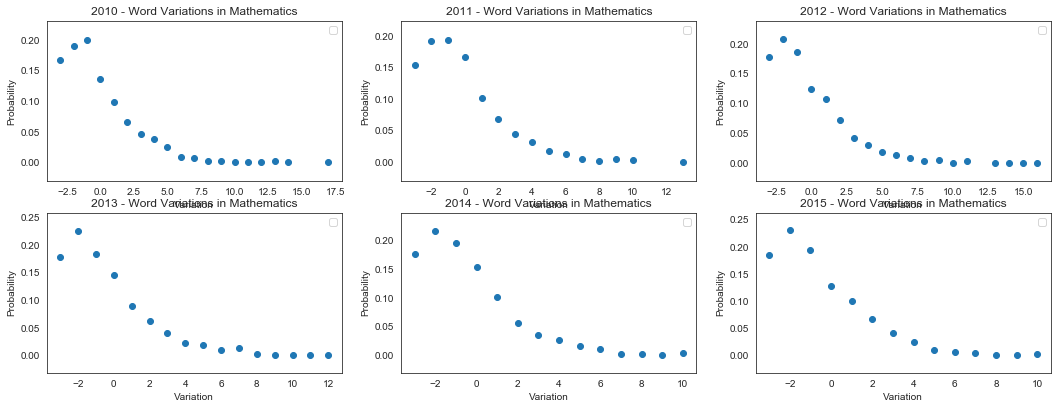

In [19]:
K = 3
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


646 words with 5 counts
720 words with 5 counts
683 words with 5 counts
701 words with 5 counts
760 words with 5 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


731 words with 5 counts


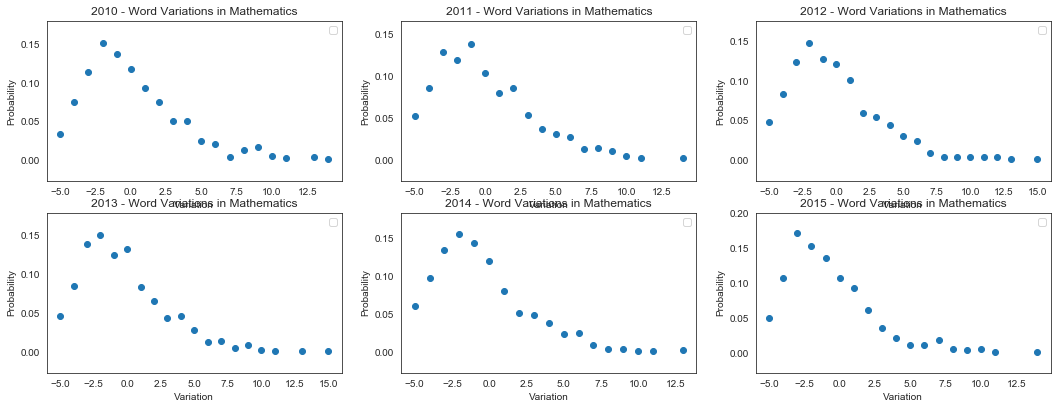

In [20]:
K = 5
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


373 words with 7 counts
412 words with 7 counts
394 words with 7 counts
452 words with 7 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


440 words with 7 counts
442 words with 7 counts


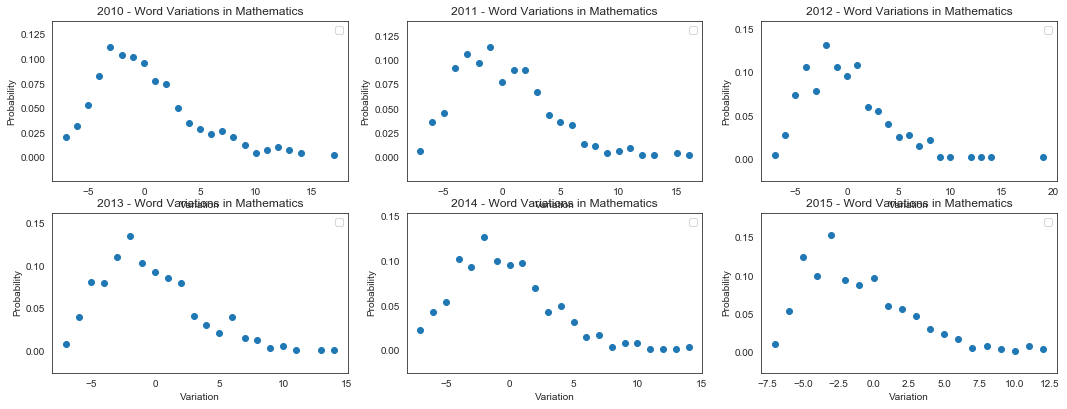

In [21]:
K = 7
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


219 words with 10 counts
227 words with 10 counts
250 words with 10 counts
249 words with 10 counts
273 words with 10 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


254 words with 10 counts


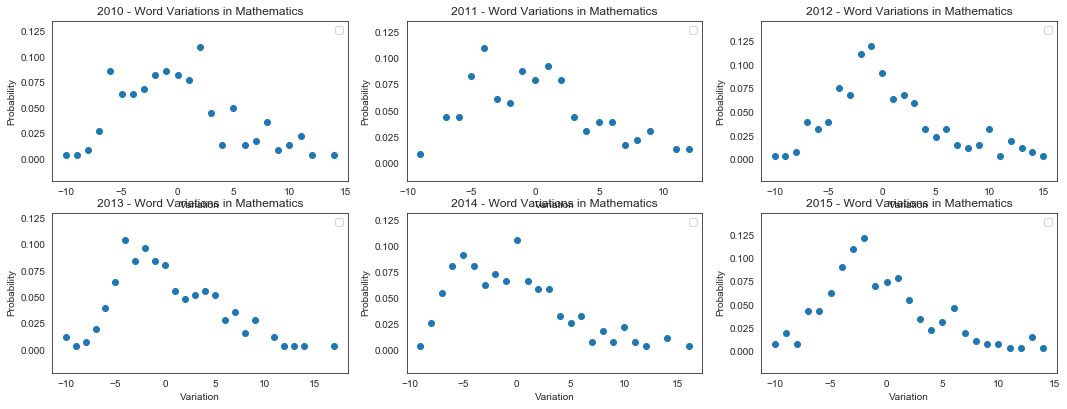

In [22]:
K = 10
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


110 words with 15 counts
161 words with 15 counts
124 words with 15 counts
123 words with 15 counts
151 words with 15 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


125 words with 15 counts


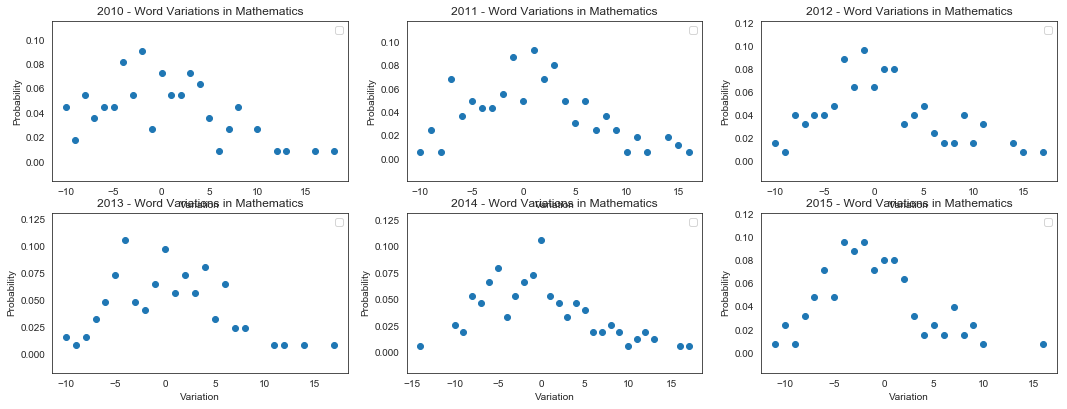

In [23]:
K = 15
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

In [29]:
counts_ = dict(Counter(variations)).values()
counts_

dict_values([12, 15, 9, 1, 6, 10, 13, 3, 8, 9, 8, 2, 5, 2, 1, 11, 7, 3, 5, 2, 2, 1, 1, 1])

In [27]:
len(indices)

137

No handles with labels found to put in legend.


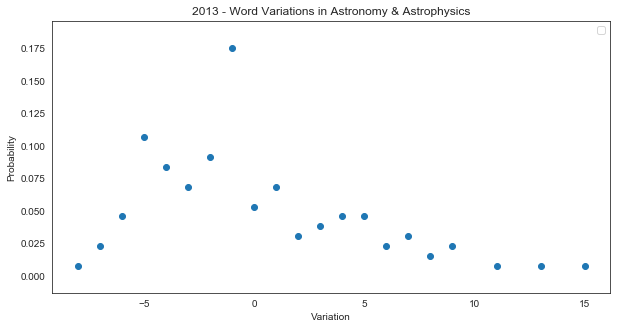

In [32]:
year = 2013

N = 112
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  


f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


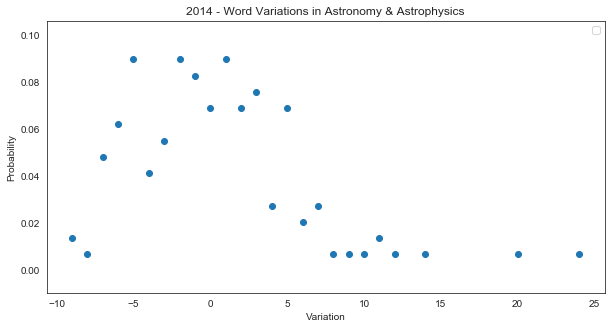

In [33]:
year = 2014

N = 113
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]


variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


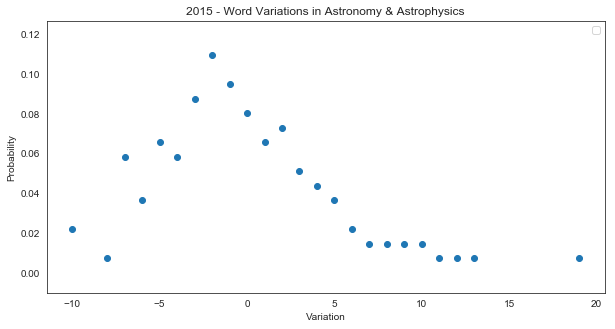

In [34]:
year = 2015

N = 114
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()